# Marti Cobos Code Analysis and explanation

*Made by: David Serrano for the Bachelor's Final Thesis*

To test and show how the code works it will be tested only with one file:

*EXAMPLE_FILE = '20171207.039_AEQ11'*

In [1]:
# Useful general imports
import json
import numpy as np
import os
from os import walk
import time
import h5py
import cv2
import joblib
from google.colab import drive
from random import random
import matplotlib.pyplot as plt
from sklearn import manifold

In [2]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Add the folder called utils (and utils/pyimagesearch) that has all the cusotms
# modueles in .py files

# Some of the functions defined in those files will be used later

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TFG/utils')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TFG/utils/pyimagesearch')

In [4]:
# Prepare the environment
from google.colab.patches import cv2_imshow

# Name of a random .h5 file to show how the functions work
# Name without extension .h5
EXAMPLE_FILE = '20171207.039_AEQ11'

# PATHS of different files and folders of the project

# Project Root folder
PROJECT_ROOT = '/content/drive/My Drive/Colab Notebooks/TFG'

# Folder of the HDF5 (videos) files
HDF5_FOLDER = PROJECT_ROOT + "/HDF5 files/"
EXAMPLEHDF5_PATH = HDF5_FOLDER + EXAMPLE_FILE + ".h5"

# Folder of the final labeled sequences
JSON_FOLDER = PROJECT_ROOT + "/data/Sequence Labeled/"
EXAMPLEJSON_PATH = JSON_FOLDER + EXAMPLE_FILE + ".h5.json"

In [5]:
# custom imports
import archive
import backgroundSubstractor
import classification
#import hdf5Calibrator
import hdf5Converter
import hdf5Loader
import hdf5Tools
import hotSpotDetector
import image_tools
import imageAnalysis
import JSONLoader
import sequenceAnalyzer
import tracker
import centroidtracker
import trackableobject
from joblib import load

In [6]:
# Load the data.json file
# which contains all the name possibilities for a filename
DATA_PATH = PROJECT_ROOT + '/data.json'
data = JSONLoader.loadData(DATA_PATH)

In [7]:
# Load the sequnce example
print('Loading sequence file...')
f = h5py.File(EXAMPLEHDF5_PATH, 'r', driver='core')
t = time.time()
images = f['ROIP']['ROIP1']['ROIP1Data'][()]
timestamps = f['ROIP']['ROIP1']['ROIP1W7XTime'][()]
elapsed = time.time() - t
f.close()
print('Elapsed time reading: {}'.format(elapsed))

Loading sequence file...
Elapsed time reading: 72.6531126499176


## Frame-Based classifier

This classifier analyzes frame by frame the sequence, as well as labeling the frames. In other words, if for example in frame of a given sequence, we have a HotSpot detected and in the next frame too, in the same position, that means that the HotSpot is the same. The program do not realise that are the same and count that as 2 HotSpots.

### analyze_Sequence_Detector.py (6)

This file analyzes all the HDF5 files. For each file, it creates a **SequenceAnalyzer** object passing as parameters the path and the timestamps of the file and it uses the *sequenceAnalyzer.processSequnce* function. This class analyzes the the whole sequence, adquiring all the images and storing them in an 3D-array. 

The function mentioned before, creates a **hotSpotDetector** object as well as a **tracker** object. The function *hotSpotDetector.detectHotSpot* is called and using other functions of the same class such as *applyTopHat*, *applayOtsu*, *process_image* and *get_detections*, it finds connected components as detections and applies a non maxima supression algorith to merge similar detections using image binarization. It returns the candidate Bounding Boxes and the image binarized. The **tracker** object deals with the detection cadidates using *tracker.update* and *centroidTrackers* which links the detections of successive frames to know if they were from the same factor.

At the end we obtain a detection array in which all the detections are stored in a json file in the /data /detections folder in the following way:
[frame number, 0, x0, y0, x1, y2, 1]

Furthermore, the line 125 of the *sequenceAnalyzer.py* is comented to avoid collapsing the notebook showing to many images.

In [8]:
i = 0
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        # original file.endswith('.h5')
        if file == (EXAMPLE_FILE + '.h5'):
            t = time.time()
            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + file

                [T1, T4, T4e] = archive.getT1T4(file)

                sequenceProcessor = sequenceAnalyzer.sequenceAnalyzer(sourceFile, T1, T4, T4e)

                print('Analyzing video sequence...')
                sequenceProcessor.processSequence()

                elapsed = time.time() - t

                print('Total Elapsed time: {}'.format(elapsed))

20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 75.38878679275513
Computing Dark image...
Elapsed time computing dark image: 3.814173698425293
Computing Dark image...
Elapsed time computing dark image: 1.965240240097046
Analyzing video sequence...
Processing Sequence image...


100%|██████████| 700/700 [05:45<00:00,  2.03it/s]


Elapsed time calibrating: 345.77967381477356
Total Elapsed time: 438.4178111553192


Now we have a lot of HotSpots candidates and its Bounding Boxes. Let's observe the first 10 detections:

In [9]:
path = PROJECT_ROOT + '/tests/detections/' + EXAMPLE_FILE + '.h5.json'
detections = JSONLoader.loadData(path)

print('The first 10 detections are:')
for d in detections[:10]:
    print(d)

The first 10 detections are:
[1, 0, 771, 502, 874, 761, 1]
[1, 0, 237, 512, 381, 751, 1]
[1, 0, 238, 438, 251, 466, 1]
[1, 0, 576, 260, 852, 427, 1]
[1, 0, 378, 256, 398, 291, 1]
[1, 0, 308, 116, 459, 243, 1]
[2, 0, 158, 0, 1191, 1024, 1]
[2, 0, 129, 647, 147, 731, 1]
[3, 0, 158, 0, 1191, 1024, 1]
[3, 0, 129, 598, 147, 731, 1]


and plot all the detections of one frame (e.g. the frame number 85):
As now we only have the detections, we do not know if the detections are NoHotSpot or HotSpot.

Computing Dark image...
Elapsed time computing dark image: 4.336596965789795


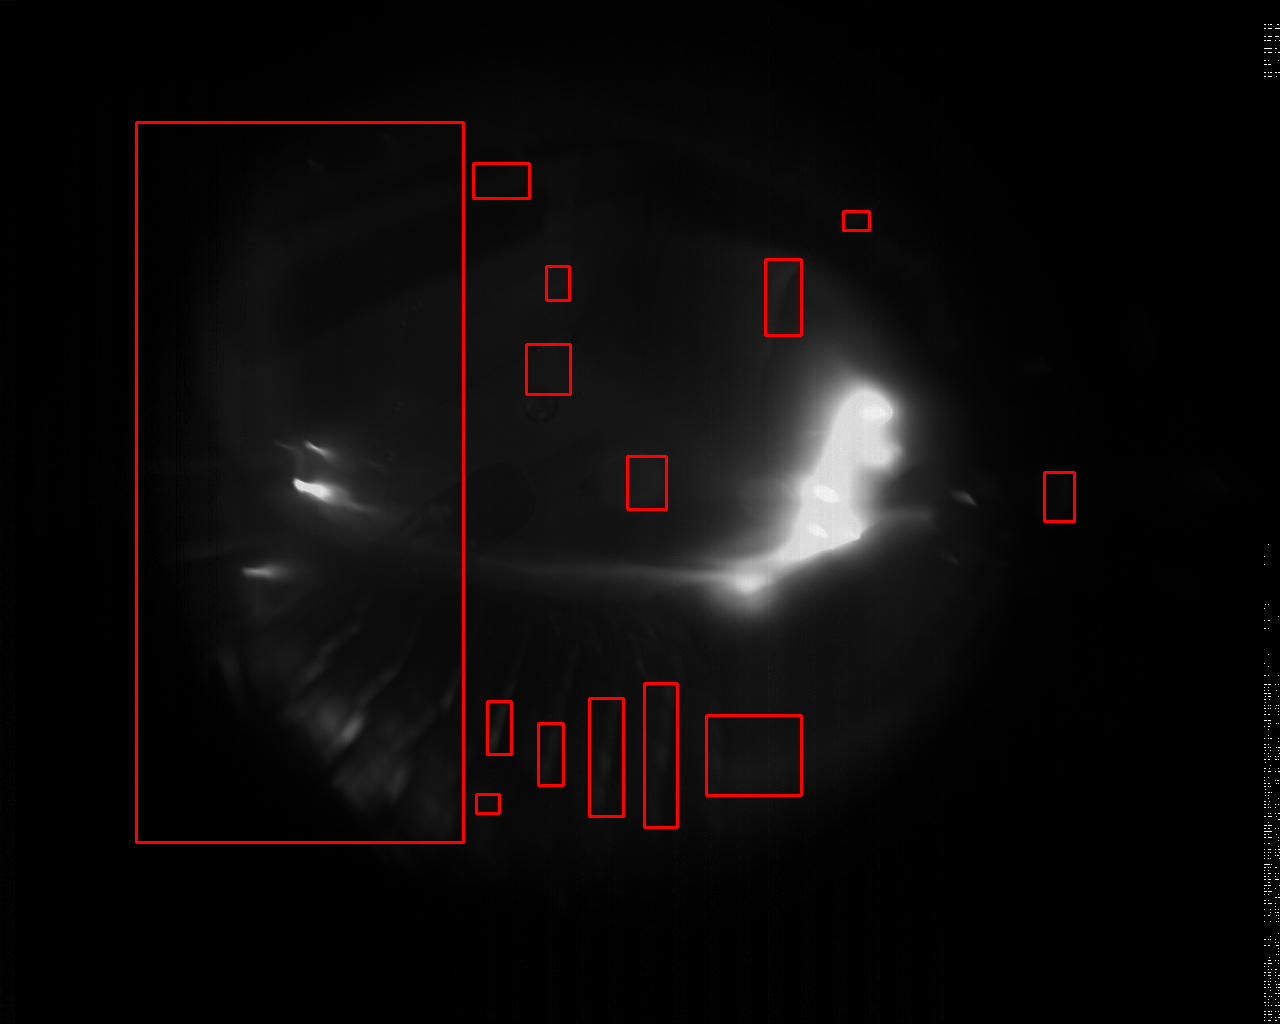

In [10]:
path = PROJECT_ROOT + '/tests/detections/' + EXAMPLE_FILE + '.h5.json'
detections = JSONLoader.loadData(path)
frame_detections = []
FRAME_NUMBER = 85

# Get the frame detections
for d in detections:
    if d[0] == FRAME_NUMBER:
        # Take only the BBox and the label (by now it is always 1)
        frame_detections.append([d[2], d[3], d[4], d[5], d[6]])

# As by now we only want to display the image we will process it to be able to
# visualize it better.
image = images[:,:,FRAME_NUMBER]
# compute its dark image and make the difference
darkIm = image_tools.computeDarkImage(images)
image = image - darkIm

image = image_tools.rescaleImage(image)
image = image_tools.adjustGamma(image)

# Plot the frame detections BBoxes
bbox_image = image_tools.plotBBoxes(image, frame_detections)
image_tools.showImage(bbox_image)

### labeling_generate_database.py (7)
This file analyzes the detections and permits labeling them manually.

The first question is: if the detection is valid. If it is, press enter, if not press any other key.
The second question is: if the valid detection is HotSpot or NoHotSpot. If it is a HotSpot press 0, if NoHotSpot press 1.

In the following block the code has been modified to only label 2 detections to show how it works.

At the end we obtain a detection array in which all the detections are stored in a json file in the /data /dataset in the following way:

[frame number, 0, x0, y0, x1, y2, 0or1]


20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 69.97440958023071
Computing Dark image...
Elapsed time computing dark image: 2.2797305583953857
Analyzing video sequence...


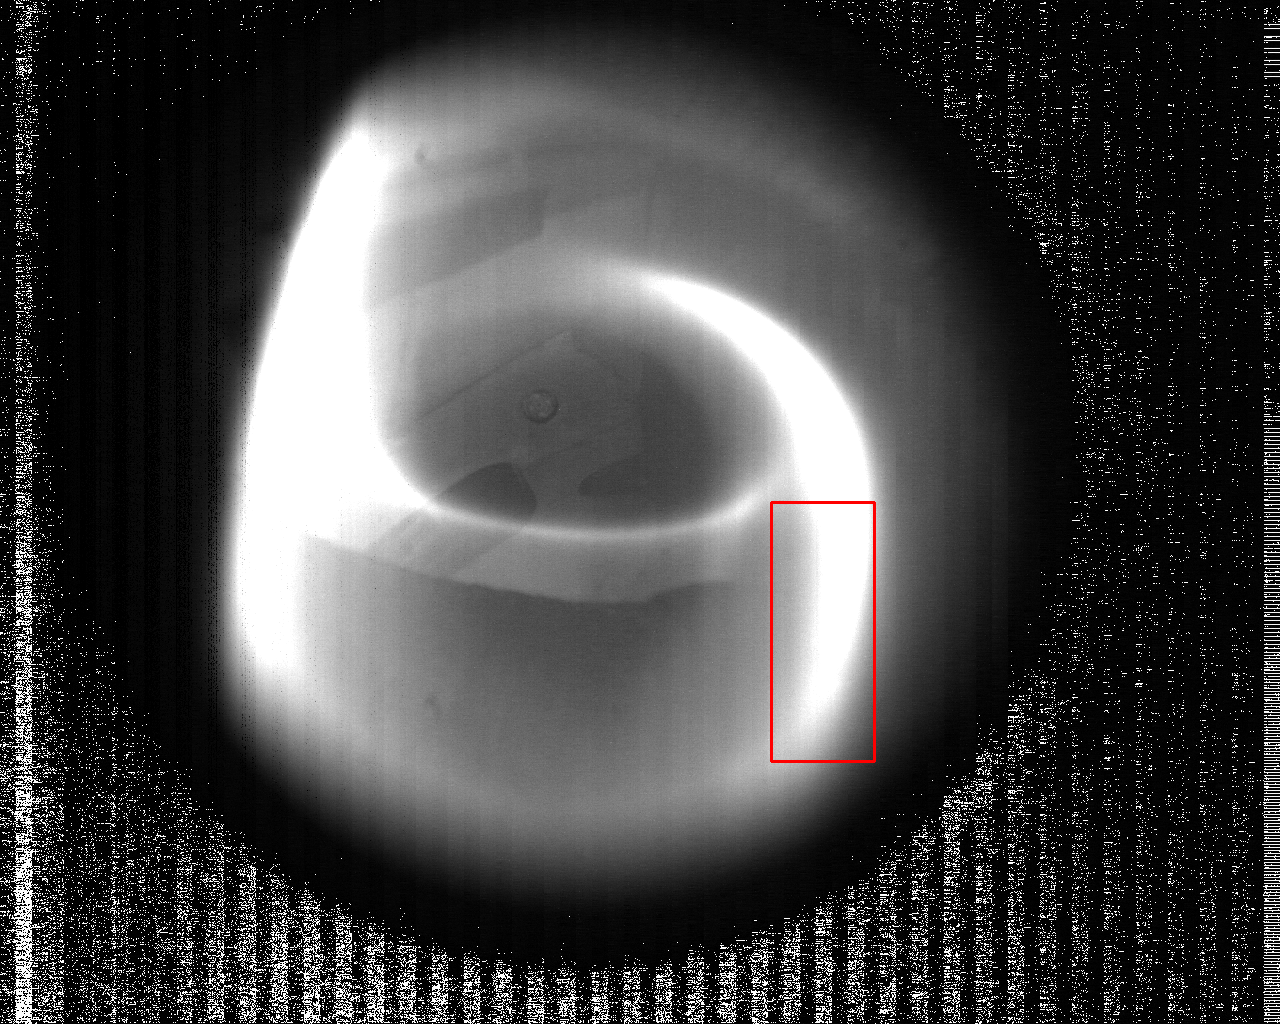

Valid?
Hotpot?0
Number Hot Spots: 1
Number Other: 0


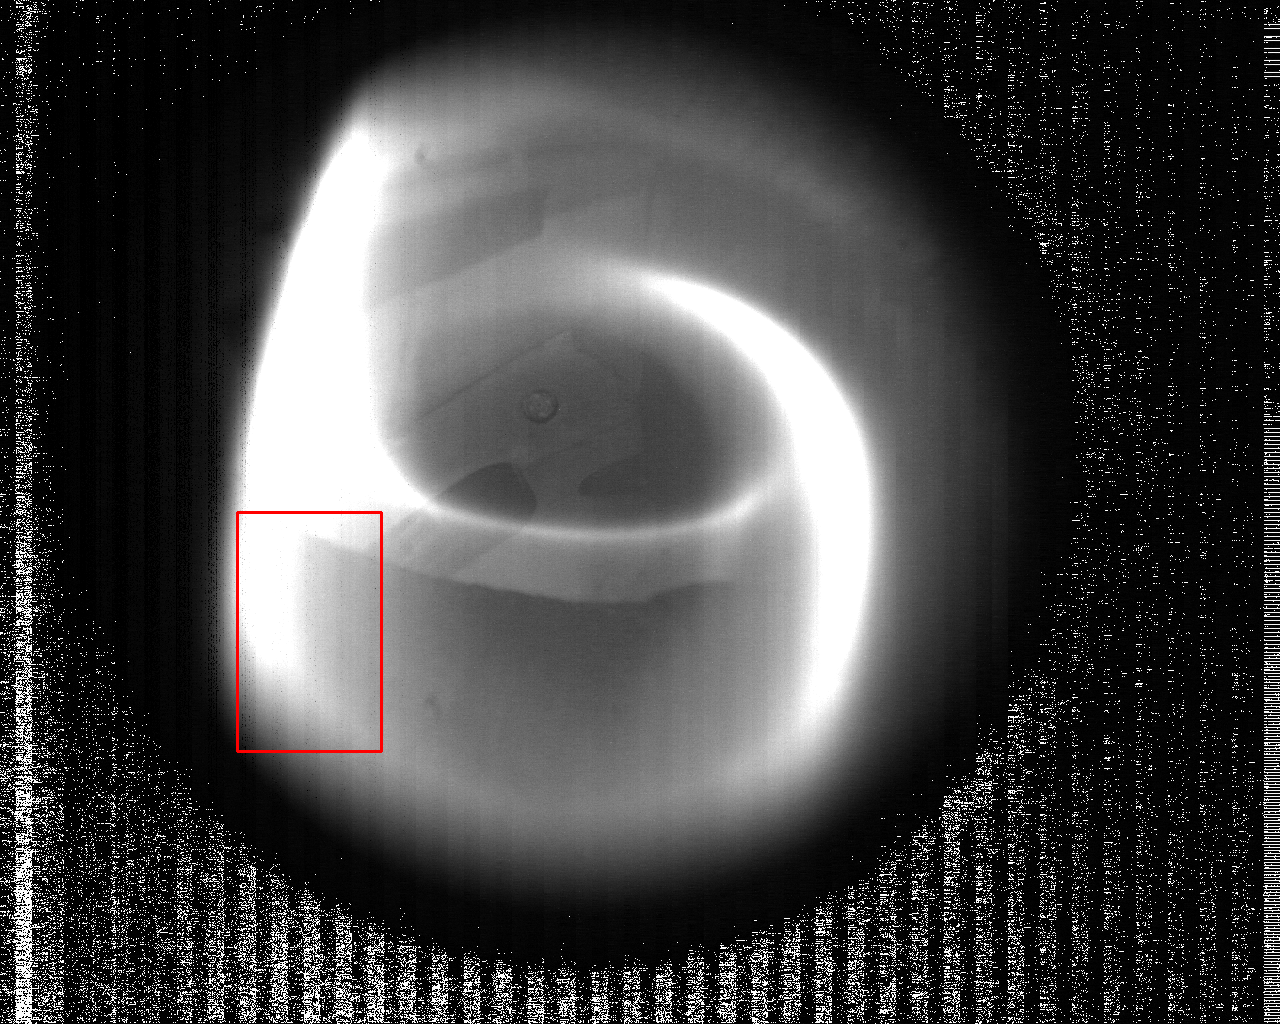

Valid?
Hotpot?1
Number Hot Spots: 1
Number Other: 0
Elapsed time: 22.821277379989624


In [11]:
#analyzedSequences = ["20180906.036_AEQ10.h5","20180906.036_AEQ51.h5","20171207.039_AEQ11.h5", "20171207.043_AEQ11.h5", "20180918.036_AEQ50.h5" , "20180918.038_AEQ50.h5", "20180918.040_AEQ50.h5", "20180918.045_AEQ50.h5"]
#analyzedSequences = ["", ""]

for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        
        # original: file.endswith('.h5') and not (file in analyzedSequences):
        if file == (EXAMPLE_FILE + '.h5'):
            t = time.time()
            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + file
                
                [T1, T4, T4e] = archive.getT1T4(file)
                images = []

                # Load the file in which we have stored the detections
                filename = PROJECT_ROOT + '/tests/detections/' + file + '.json'
                detections = JSONLoader.loadData(filename)

                print('Loading sequence file...')
                f = h5py.File(sourceFile, 'r', driver='core')
                t = time.time()
                images = f['ROIP']['ROIP1']['ROIP1Data'][()]
                timestamps = f['ROIP']['ROIP1']['ROIP1W7XTime'][()]
                elapsed = time.time() - t
                f.close()
                print('Elapsed time reading: {}'.format(elapsed))

                print('Computing Dark image...')
                t = time.time()
                aux = np.zeros([images.shape[0], images.shape[1], 30])
                nFrames = images.shape[2]
                for i in range(30):
                    aux[:, :, i] = (images[:, :, nFrames - i - 1])
                darkImage = np.median(aux, axis=2)
                elapsed = time.time() - t
                print('Elapsed time computing dark image: {}'.format(elapsed))
                
                # label the detections as HotSpot or Others
                print('Analyzing video sequence...')
                dataset = []
                nhot = 0
                nOther = 0
                # Original: for detection in detections:
                for detection in detections[:2]:
                    
                    val = random()
                    analyze = val > 0

                    if analyze:
                        imageDetection = images[:, :, detection[0]]-darkImage

                        imageDetection = image_tools.preProcess(imageDetection)
                        frame_detections=[]
                        frame_detections.append([detection[2], detection[3], detection[4], detection[5]])
                        imageDetection = image_tools.plotBBoxes(imageDetection, frame_detections)
                        image_tools.showImage(imageDetection)
                        # for avoiding crashing
                        time.sleep(5)
                        print("===========")
                        value = input("Valid?")

                        # If value is 0 -> hotSpot = True
                        # If value is 1 -> hotSpot = False
                        if value == "":
                            value = input("Hotpot?")
                            hotSpot = False
                            if value == "0":
                                hotSpot = True
                            if hotSpot and nhot < 50:
                                # 1 --> Hot Spot
                                dataset.append(
                                    [detection[0], 0, detection[2], detection[3], detection[4], detection[5],
                                    1])
                                nhot = nhot +1
                            elif value == "" and nOther < 50:
                                # 0 --> No Hot Spot
                                dataset.append(
                                    [detection[0], 0, detection[2], detection[3], detection[4], detection[5],
                                    0])
                                nOther = nOther + 1
                        elif value == "q":
                            break
                        if nhot >= 50 and nOther >= 50:
                            break
                        print('Number Hot Spots: {}'.format(nhot))
                        print('Number Other: {}'.format(nOther))


                filename = PROJECT_ROOT + '/tests/dataset/' + file + 'TEST' '.h5.json'
                #filename = os.path.join("data", "dataset", os.path.basename(sourceFile) + ".json")
                JSONLoader.saveData(filename, dataset)
                elapsed = time.time() - t

                print('Elapsed time: {}'.format(elapsed))

### analyze_database.py (8_1)
This file analyzes the dataset files and returns a set of characteristics with the function *extractCharacteristics* of the class **imageAnalysis**. The characteristics extracted are the following:

detection:
 - detection[0]:   frame number
 - detection[1]:   trackID (at the moment always 0)
 - detection[2:5]: Bounding Box
 - detection[6]:   label
 - detection[7]:  BBox Area
 - detection[8]: BBox Width
 - detection[9]: BBox Height
 - detection[10]: Form Factor (Width/Height)
 - detection[11]: Fill Factor (Area/(Width/Height))
 - detection[12]: X centroid
 - detection[13]: Y centroid
 - detection[14]: BBox Mean Intensity
 - detection[15]: Image Mean Intensity
 - detection[16:(16+nBins)]: BBox Intensity Histogram
 - detection[(16+nBins):(16+nBins+10)]: Histogram LBP
 - detection[(16+nBins+11)]: Ring Intensity Mean
 - detection[(16+nBins+12:(16+nBins+13+nBins)]: Ring Intensity Histogram



In [12]:
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:

        # Original: file.endswith('.h5') and not (file in analyzedSequences):
        if file == (EXAMPLE_FILE + '.h5'):
            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + file

                [T1, T4, T4e] = archive.getT1T4(file)
                images = []

                filename = PROJECT_ROOT + '/tests/dataset/' + file + '.json'

                if os.path.exists(filename):
                    detections = JSONLoader.loadData(filename)

                    #Load Sequence File
                    print('Loading sequence file...')
                    f = h5py.File(sourceFile, 'r', driver='core')
                    t = time.time()
                    images = f['ROIP']['ROIP1']['ROIP1Data'][()]
                    timestamps = f['ROIP']['ROIP1']['ROIP1W7XTime'][()]
                    elapsed = time.time() - t
                    f.close()
                    print('Elapsed time reading: {}'.format(elapsed))

                    darkImage = image_tools.computeDarkImage(images)

                    # Analyze video sequence
                    print('Analyzing video sequence...')
                    characteristics = []

                    for detection in detections:

                        blobCharacteristics = []

                        imageDetection = images[:, :, detection[0]]-darkImage
                        imageVisualization = image_tools.preProcess(darkImage)
                        #image_tools.showImage(imageVisualization)

                        imageVisualization = image_tools.preProcess(imageDetection)
                        frame_detections = []
                        frame_detection = [detection[2], detection[3], detection[4], detection[5]]
                        frame_detections.append(frame_detection)
                        imageVisualization = image_tools.plotBBoxes(imageVisualization, frame_detections)
                        #image_tools.showImage(imageVisualization)


                        blobCharacteristics = [float(detection[0]), float(detection[1]), float(detection[2]), float(detection[3]), float(detection[4]),
                                                float(detection[5]), float(detection[6])]

                        extractedCharacteristics = imageAnalysis.extractCharacteristics(imageDetection, frame_detection)

                        if extractedCharacteristics != [] :
                            for characteristic in extractedCharacteristics:
                                blobCharacteristics.append(characteristic)

                            characteristics.append(blobCharacteristics)

                    filename = PROJECT_ROOT + '/tests/characteristics/' + file + '.h5.json'
                    JSONLoader.saveData(filename, characteristics)
                    elapsed = time.time() - t

                    print('Elapsed time: {}'.format(elapsed))

20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 70.15846729278564
Computing Dark image...
Elapsed time computing dark image: 3.782564878463745
Analyzing video sequence...
Elapsed time: 133.00563073158264


### analyze_data.py (8_2)
This function analyzes the extracted characteristics and show them.

20171207.039_AEQ11.h5.json


SCATTER PLOTS of ROIArea, ROIFormFactor, ROIFillFactor, ROIMean/ImageMean, Centroids and ring characteristics:



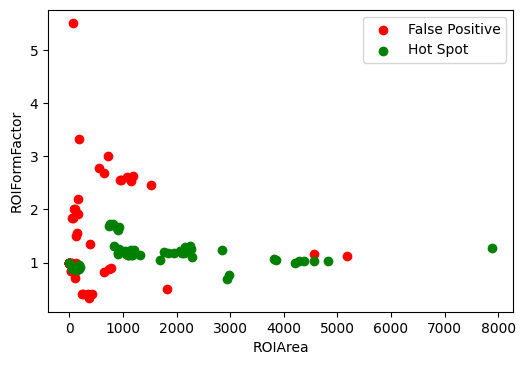

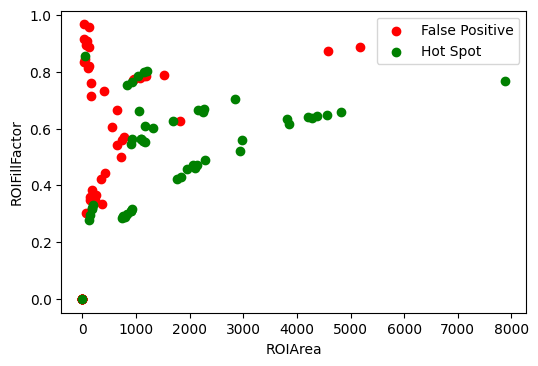

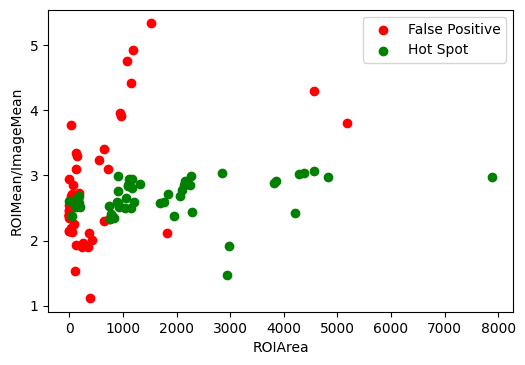

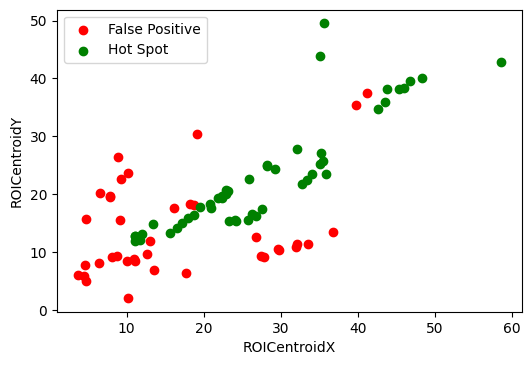

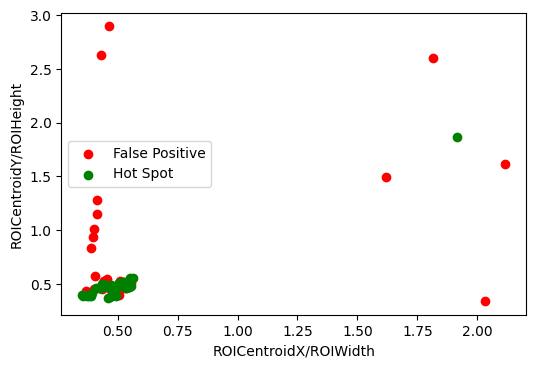

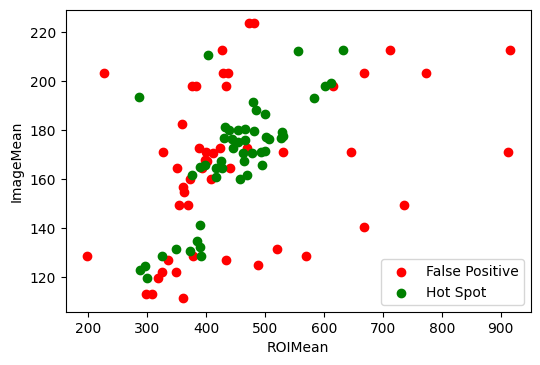

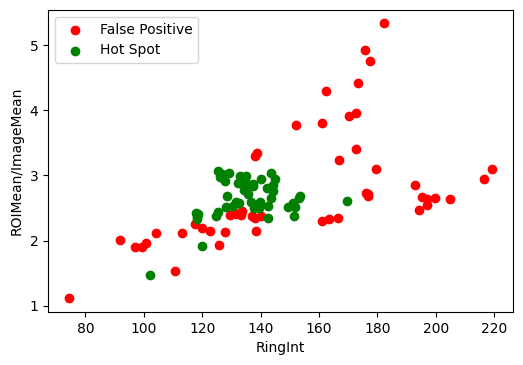

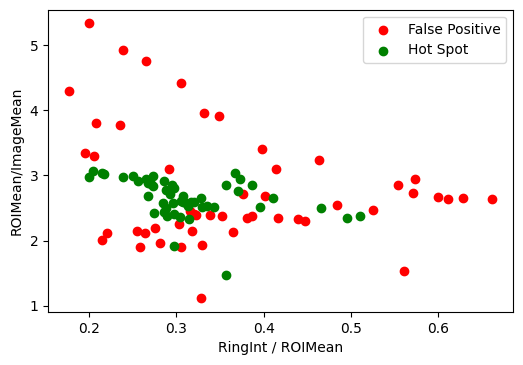



ROI HISTOGRAM:
RED - Other
GREEN - HotSpot



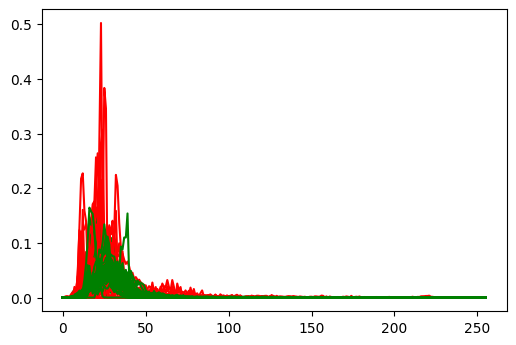


ROI HISTOGRAM LBP:
RED - Other
GREEN - HotSpot



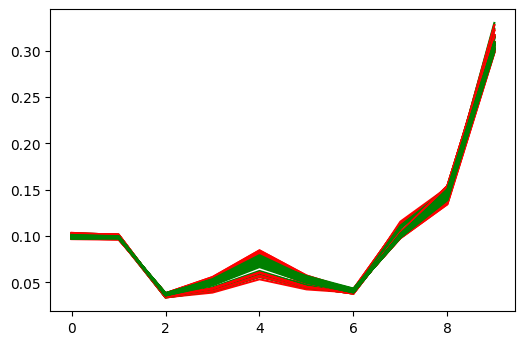


ROI HISTOGRAM:
RED - Other
GREEN - HotSpot



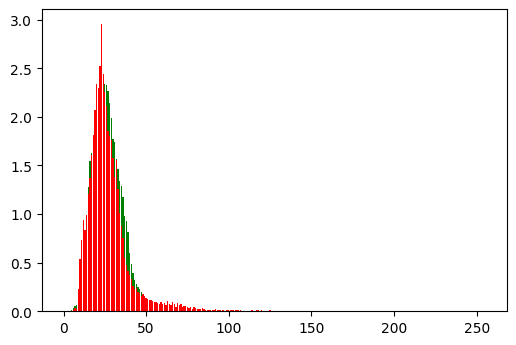


ROI HISTOGRAM LBP:
RED - Other
GREEN - HotSpot



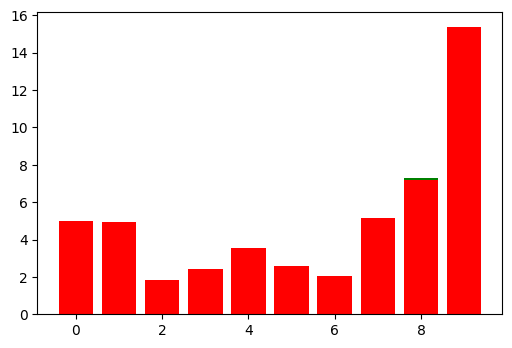

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.013s...
[t-SNE] Computed neighbors for 100 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 58.603903
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.846718
[t-SNE] KL divergence after 1000 iterations: 0.569793
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.002s...
[t-SNE] Computed neighbors for 100 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 58.603903
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.846718
[t-SNE] KL divergence after 1000 iterations: 0.569793


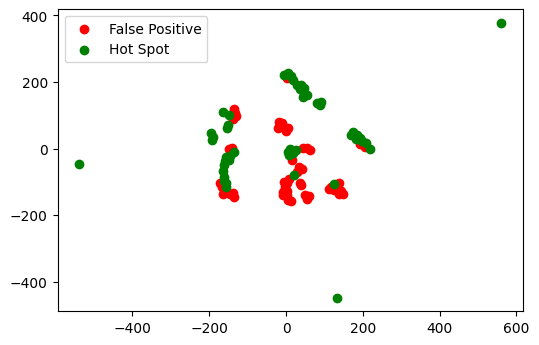

Elapsed time: 4.9422125816345215


In [13]:
path = PROJECT_ROOT + '/tests/characteristics/'
for (dirpath, dirnames, filenames) in walk(path):
    for file in filenames:
        # Origianl: file.endswith('.h5.json') and (file in sequencesToAnalyze):
        if file == (EXAMPLE_FILE + '.h5.json'):
            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            port = port[:-3]
            if [xp, port] in data:
                print('{}\n'.format(file))
                sourceFile = dirpath + '/' + file
                #try:

                filename = PROJECT_ROOT + '/tests/characteristics/' + file
                characteristics = JSONLoader.loadData(filename)

                nBins = 256

                sequenceData = classification.arrangeData(characteristics)
                ROIClass = sequenceData[6,:]
                ROIArea = sequenceData[7, :]
                ROIWidth = sequenceData[8, :]
                ROIHeight = sequenceData[9,:]
                ROIFormFactor = sequenceData[10, :]
                ROIFillFactor = sequenceData[11, :]
                ROICentroidX = sequenceData[12, :]
                ROICentroidY = sequenceData[13, :]
                ROIMean = sequenceData[14, :]
                ImageMean = sequenceData[15, :]
                aux0 = int(16 + nBins)
                ROIHist = sequenceData[16:aux0 , :]
                aux1 = int(aux0 + 10)
                ROIHistLBP = sequenceData[aux0:aux1, :]
                RingMean = sequenceData[aux1, :]
                aux2 = int(aux1 +1 + nBins)
                RingHist = sequenceData[int(aux1+1):aux2, :]
                RingInt = np.nan_to_num(sequenceData[aux2, :])

                xData = np.nan_to_num(sequenceData[7:, :])
                yData = sequenceData[6,:]

                plot = True

                if plot:
                    # ROI Hist for HS
                    ROIHistLBPHS = np.zeros(ROIHistLBP[:, 1].size)
                    # ROI Hist for False Positives
                    ROIHistLBPFP = np.zeros(ROIHistLBP[:, 1].size)

                    # print('HISTOGRAM LBP:')
                    # print('RED - other')
                    # print('GREEN - HotSpot\n')
                    # for i in range(len(characteristics)):
                        # if ROIClass[i] == 0:
                            # color = 'r'
                            # ROIHistLBPFP = ROIHistLBPFP + ROIHistLBP[:, i]
                        # else:
                            # color = 'g'
                            # ROIHistLBPHS = ROIHistLBPHS + ROIHistLBP[:, i]
                        # plt.plot(ROIHistLBP[:,i], color)
                    # plt.show()



                    # x = np.arange(ROIHistLBPHS.size)
                    # #fig, ax = plt.subplots()
                    # width = 0.35  # the width of the bars
                    # rects1 = ax.bar(x - width / 2, ROIHistLBPHS, width, label='HS', color = 'g')
                    # rects2 = ax.bar(x + width / 2, ROIHistLBPFP, width, label='FP', color = 'r')
                    # #plt.show()

                    print('\nSCATTER PLOTS of ROIArea, ROIFormFactor, ROIFillFactor, ROIMean/ImageMean, Centroids and ring characteristics:\n')
                    classification.scatterPlot(ROIArea, ROIFormFactor, 'ROIArea', 'ROIFormFactor', ROIClass)
                    print('')
                    classification.scatterPlot(ROIArea, ROIFillFactor, 'ROIArea', 'ROIFillFactor', ROIClass)
                    print('')
                    classification.scatterPlot(ROIArea, ROIMean/ImageMean, 'ROIArea', 'ROIMean/ImageMean', ROIClass)
                    print('')
                    classification.scatterPlot(ROICentroidX, ROICentroidY, 'ROICentroidX', 'ROICentroidY', ROIClass)
                    print('')
                    classification.scatterPlot(ROICentroidX/ROIWidth, ROICentroidY/ROIHeight, 'ROICentroidX/ROIWidth', 'ROICentroidY/ROIHeight', ROIClass)
                    print('')
                    classification.scatterPlot(ROIMean, ImageMean, 'ROIMean', 'ImageMean', ROIClass)
                    print('')
                    classification.scatterPlot(RingInt, ROIMean/ImageMean, 'RingInt', 'ROIMean/ImageMean', ROIClass)
                    print('')
                    classification.scatterPlot(RingInt / ROIMean, ROIMean / ImageMean, 'RingInt / ROIMean', 'ROIMean/ImageMean', ROIClass)
                    print('')

                    ROIHistHS = np.zeros(ROIHist[:,1].size)
                    ROIHistFP = np.zeros(ROIHist[:,1].size)

                    print('\nROI HISTOGRAM:')
                    print('RED - Other')
                    print('GREEN - HotSpot\n')

                    for i in range(len(characteristics)):
                        if ROIClass[i] == 0:
                            color = 'r'
                            ROIHistFP = ROIHistFP + ROIHist[:,i]
                        else:
                            color = 'g'
                            ROIHistHS = ROIHistHS + ROIHist[:,i]

                        plt.plot(ROIHist[:,i], color)
                    plt.show()

                    ROIHistLBPHS = np.zeros(ROIHistLBP[:, 1].size)
                    ROIHistLBPFP = np.zeros(ROIHistLBP[:, 1].size)

                    print('\nROI HISTOGRAM LBP:')
                    print('RED - Other')
                    print('GREEN - HotSpot\n')

                    for i in range(len(characteristics)):
                        if ROIClass[i] == 0:
                            color = 'r'
                            ROIHistLBPFP = ROIHistLBPFP + ROIHistLBP[:, i]
                        else:
                            color = 'g'
                            ROIHistLBPHS = ROIHistLBPHS + ROIHistLBP[:, i]
                        plt.plot(ROIHistLBP[:,i], color)
                    plt.show()

                    print('\nROI HISTOGRAM:')
                    print('RED - Other')
                    print('GREEN - HotSpot\n')

                    x = np.arange(ROIHistHS.size)
                    plt.bar(x, ROIHistHS, color = 'g')
                    plt.bar(x, ROIHistFP, color='r')
                    plt.show()

                    print('\nROI HISTOGRAM LBP:')
                    print('RED - Other')
                    print('GREEN - HotSpot\n')

                    x = np.arange(ROIHistLBPHS.size)
                    plt.bar(x, ROIHistLBPHS, color='g')
                    plt.bar(x, ROIHistLBPFP, color='r')
                    plt.show()

                    #dimensionality reduction

                    n_components = 2
                    perplexity = 5

                    tsne = manifold.TSNE(n_components=n_components, verbose=1, init='random',
                                            random_state=0, perplexity=perplexity)
                    Y = tsne.fit(xData.transpose())
                    Y_2 = tsne.fit_transform(xData.transpose())

                    a= Y_2[:,0]
                    b = Y_2[:, 1]

                    classification.scatterPlot(a, b, '', '', ROIClass)



                elapsed = time.time() - t
                print('Elapsed time: {}'.format(elapsed))

                #except Exception as e:
                #    print('Error opening file')
                #    print(e)

### classify.py (9)
This file trains and test a SVM classifier:

/content/drive/My Drive/Colab Notebooks/TFG/data/characteristics/
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished


Test results with best estimator:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       202
         1.0       0.94      0.89      0.91        53

    accuracy                           0.96       255
   macro avg       0.96      0.94      0.95       255
weighted avg       0.96      0.96      0.96       255

Test Accuracy: 0.8941176470588236
Test F1: 0.7272727272727273
Test Precision: 0.782608695652174
Test Recall: 0.6792452830188679
Elapsed time: 2.721726655960083


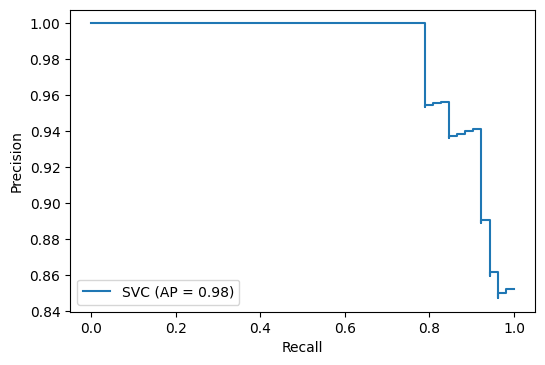

In [14]:
sequencesToAnalyze = ["20180906.036_AEQ10.h5","20180906.036_AEQ51.h5",
                        "20171207.039_AEQ11.h5", "20171207.043_AEQ11.h5",
                        "20180918.036_AEQ50.h5" , "20180918.038_AEQ50.h5"]

characteristics_path = PROJECT_ROOT + '/data/characteristics/'

init = True

for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        if file.endswith('.h5') and (file in sequencesToAnalyze):

            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))


            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:

                sourceFile = dirpath + '/' + file

                #try:
                filename = characteristics_path + file + '.json'
                characteristics = JSONLoader.loadData(filename)

                nBins = 256

                sequenceData = classification.arrangeData(characteristics)

                if init:
                    xData = np.nan_to_num(sequenceData[7:, :])
                    yData = sequenceData[6,:]
                    init = False
                else:
                    xData = np.concatenate((xData, np.nan_to_num(sequenceData[7:, :])), axis = 1)
                    yData = np.concatenate((yData,sequenceData[6, :]), axis = 0)


#Get test data
print(characteristics_path)
initTrain = True
for (dirpath, dirnames, filenames) in walk(characteristics_path):
    for file in filenames:
        if file.endswith('.json'):

            characteristics = JSONLoader.loadData(filename)

            nBins = 256

            sequenceData = classification.arrangeData(characteristics)

            if init:
                xDataTrain = np.nan_to_num(sequenceData[7:, :])
                yDataTrain = sequenceData[6, :]
                initTrain = False
            else:
                xDataTrain = np.concatenate((xData, np.nan_to_num(sequenceData[7:, :])), axis=1)
                yDataTrain = np.concatenate((yData, sequenceData[6, :]), axis=0)

#Train SVM
searchN = False
if not searchN:
    # Create the classification object
    clf = classification.data_classifier(n=9)
    xData_normalized = clf.normalize_data(xData)
    clf.train_classifier_precision_recall_curve(xData_normalized, yData)
    #clf.train_classifier_GS(xData_normalized, yData, groups=5 )
    classification.saveModel(clf)

    xDataTrain_normalized = clf.normalize_data(xDataTrain, fit = False)
    clf.predictLabel(xDataTrain_normalized, yDataTrain)
    #clf.probability(xDataTrain_normalized, yDataTrain)
    threshold = 0.5
    clf.predict_probability(xDataTrain_normalized, yDataTrain,threshold)



# else:
#     for i in range(2,10):
#         clf = classification.data_classifier(n=i)
#         xData_normalized = clf.normalize_data(xData)
#         print('Training SVM with {} PCA components'.format(i))
#         clf.train_classifier_GS(xData_normalized, yData, 'SVM')



elapsed = time.time() - t
print('Elapsed time: {}'.format(elapsed))

# dimensionality reduction

# TSNE = False

# if TSNE:
#     n_components = 2
#     perplexity = 5

#     tsne = manifold.TSNE(n_components=n_components, verbose=1, init='random',
#                             random_state=0, perplexity=perplexity)
#     Y = tsne.fit(xData.transpose())
#     Y_2 = tsne.fit_transform(xData.transpose())

#     a = Y_2[:, 0]
#     b = Y_2[:, 1]

#     scatterPlot(a, b, '', '', yData)    

## Track-Based classifier
This classifier analyzes the detections of a frame and tries to link them with other frame detection with low Euclidean Distance and low difference on the area between them.

In other words, if for example in a frame of a given sequence, we have a HotSpot detected and in the next frame too, in the same position, that means that the HotSpot is the same. The program realise that are the same and count that as 1 HotSpot with the same TrackID.

After 50 frames without finding any detection similar to the analyzed one, the program asumes that the detection has disappeared. 

### track (10_1)
In this function we analyze the example sequence and track the detections to find their track, We obtain 2 .txt files with all the information.

In [15]:
def getFrameDetections(detections,i):
    frameDetections = []

    for detection in detections:
        if detection[0] == i:
            frameDetections.append(detection)
    return frameDetections

def getMaxFrame (detections):
    max =0

    for detection in detections:
        if detection[0]>max:
            max = detection[0]
    return max

In [16]:
#analyzedSequences = ["20180906.036_AEQ10.h5","20180906.036_AEQ51.h5","20171207.039_AEQ11.h5"]
analyzedSequences = ["", ""]

for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        if file == (EXAMPLE_FILE + '.h5'):

            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))
            print (filename)

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + '/' + file

                [T1, T4, T4e] = archive.getT1T4(file)

                images = []

                filename = PROJECT_ROOT + '/tests/detections/' + file + '.json'
                detections = JSONLoader.loadData(filename)

                # Load Sequence File
                if len(images)>0:
                    print('Sequnce file already loaded.')
                else:
                    print('Loading sequence file...')
                    f = h5py.File(sourceFile, 'r', driver='core')
                    t = time.time()
                    images = f['ROIP']['ROIP1']['ROIP1Data'][()]
                    timestamps = f['ROIP']['ROIP1']['ROIP1W7XTime'][()]
                    elapsed = time.time() - t
                    f.close()
                    print('Elapsed time reading: {}'.format(elapsed))

                darkImage = image_tools.computeDarkImage(images)

                file_path = PROJECT_ROOT + '/tests/tracking.txt'
                fout_pos = open(file_path, 'w')

                # Analyze video sequence
                print('Tracking Objects in Video Sequence...')
                tracks = []

                # Tracker parameters
                max_disappeared = 50
                max_distance = 10

                #Initialize tracker
                ct = centroidtracker.CentroidTracker(maxDisappeared=max_disappeared, maxDistance=max_distance)
                trackers = []
                trackableObjects = {}

                frameID = 0

                max = getMaxFrame(detections)

                #out_video = "tracking.avi"
                #fourcc = cv2.VideoWriter_fourcc(*"XVID")
                #writer = cv2.VideoWriter(out_video, fourcc, 30, (1024, 1280), True)

                for i in range(200):
                    imageDetection = images[:, :, i] - darkImage
                    imageVisualization = image_tools.preProcess(imageDetection)
                    imageVisualization = cv2.cvtColor(imageVisualization, cv2.COLOR_GRAY2RGB)
                    frameID = i
                    frameDetections = getFrameDetections(detections, i)
                    rects = []

                    for detection in frameDetections:
                        # compute the (x, y)-coordinates of the bounding box
                        # for the object [detection[2], detection[3], detection[4], detection[5]]
                        startY = int(detection[3])
                        startX = int(detection[2])
                        endX = int(detection[4])
                        endY = int(detection[5])
                        # add the bounding box coordinates to the rectangles list
                        rects.append((startX, startY, endX, endY))

                    (objects, bboxes) = ct.update(rects)

                    for (objectID, centroid) in objects.items():
                        # draw both the ID of the object and the centroid of the
                        # object on the output frame
                        text = "ID {}".format(objectID)
                        cv2.putText(imageVisualization, text, (centroid[0] - 10, centroid[1] - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        cv2.circle(imageVisualization, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
                    # image_tools.showImage(imageVisualization)
                    imageName = PROJECT_ROOT + '/tests/track/' + str(i) + '.bmp'
                    cv2.imwrite(imageName,imageVisualization)
                    #writer.write(imageVisualization)

                    # loop over the tracked objects
                    for (objectID, centroid) in objects.items():
                        # check to see if a trackable object exists for the current
                        # object ID
                        to = trackableObjects.get(objectID, None)

                        # if there is no existing trackable object, create one
                        if to is None:
                            to = trackableobject.TrackableObject(objectID, centroid, frameID, None, None, None, None, None)

                        # otherwise, there is a trackable object so we can utilize it
                        # to determine direction
                        else:
                            to.endFrame = frameID

                            to.centroids.append(centroid)

                        # store the trackable object in our dictionary
                        trackableObjects[objectID] = to
                        # Write bbox to .facetrack file
                        xmin = bboxes[objectID][0]
                        ymin = bboxes[objectID][1]
                        xmax = bboxes[objectID][2]
                        ymax = bboxes[objectID][3]
                        fout_pos.write('{} {} {} {} {} {}\n'.format(frameID, objectID, int(round(xmin, 0)),
                                                                    int(round(ymin, 0)), int(round(xmax - xmin, 0)),
                                                                    int(round(ymax - ymin, 0))))

                fout_pos.close()
                #writer.release()
                # write face segmentation
                file_path = PROJECT_ROOT + '/tests/test.txt' 
                fout_seg = open(file_path, 'w')
                trackID = 0
                for faceID in sorted(trackableObjects.keys()):
                    startFrame = trackableObjects[faceID].startFrame
                    endFrame = trackableObjects[faceID].endFrame
                    conf = endFrame - startFrame + 1

                    out_str = '{} {:06d} {:06d} {:06d} {:06d} {}\n'.format(1,
                                                                                startFrame,
                                                                                endFrame,
                                                                                trackID,
                                                                                faceID, conf)
                    fout_seg.write(out_str)
                    trackID += 1
                fout_seg.close()

20171207.039_AEQ11
20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 70.3521568775177
Computing Dark image...
Elapsed time computing dark image: 4.326399803161621
Tracking Objects in Video Sequence...
Deregistering object 0 after 50 frames
Deregistering object 1 after 50 frames
Deregistering object 2 after 50 frames
Deregistering object 3 after 50 frames
Deregistering object 4 after 50 frames
Deregistering object 5 after 50 frames
Deregistering object 9 after 50 frames
Deregistering object 10 after 50 frames
Deregistering object 11 after 50 frames
Deregistering object 12 after 50 frames
Deregistering object 8 after 50 frames
Deregistering object 6 after 50 frames
Deregistering object 7 after 50 frames
Deregistering object 33 after 50 frames
Deregistering object 25 after 50 frames
Deregistering object 26 after 50 frames
Deregistering object 14 after 50 frames
Deregistering object 36 after 50 frames
Deregistering object 30 after 50 frames
Deregistering object 35 after 

Now we have 2 txt files.

In the first (tracking.txt) we have all the detections stored by each frame as we can see on the following block.

The structure is the following:

[frame_number, trackID, x0, y0, x1, y2]

In [17]:
path = PROJECT_ROOT + '/tests/tracking.txt'
f = open(path, 'r')

detections = []
# Read only the first 20 lines
lines = f.readlines()
for line in lines[:20]:
    print(line)

1 0 771 502 103 259

1 1 237 512 144 239

1 2 238 438 13 28

1 3 576 260 276 167

1 4 378 256 20 35

1 5 308 116 151 127

2 0 771 502 103 259

2 1 237 512 144 239

2 2 238 438 13 28

2 3 576 260 276 167

2 4 378 256 20 35

2 5 308 116 151 127

3 0 771 502 103 259

3 1 237 512 144 239

3 2 238 438 13 28

3 3 576 260 276 167

3 4 378 256 20 35

3 5 308 116 151 127

4 0 771 502 103 259

4 1 237 512 144 239



In the second file (test.txt) we have the following structure:

[1, first frame appearing, last frame appearing, trackID, track ID, total frames appearing]

In [18]:
path = PROJECT_ROOT + '/tests/test.txt'
f = open(path, 'r')

detections = []
# Read only the first 20 lines
lines = f.readlines()
for line in lines[:20]:
    print(line)

1 000001 000053 000000 000000 53

1 000001 000053 000001 000001 53

1 000001 000053 000002 000002 53

1 000001 000053 000003 000003 53

1 000001 000053 000004 000004 53

1 000001 000053 000005 000005 53

1 000010 000068 000006 000006 59

1 000010 000071 000007 000007 62

1 000010 000064 000008 000008 55

1 000010 000061 000009 000009 52

1 000010 000061 000010 000010 52

1 000010 000061 000011 000011 52

1 000010 000061 000012 000012 52

1 000053 000140 000013 000013 88

1 000053 000123 000014 000014 71

1 000053 000199 000015 000015 147

1 000053 000199 000016 000016 147

1 000053 000159 000017 000017 107

1 000053 000199 000018 000018 147

1 000053 000199 000019 000019 147



### detect_and_track.py (10_2)

Same as the code of the block before but storing the output data in .json file

As the reason of this notebook is to show how the program works, only a few images with the centroids of the detections being tracked at that moment(less than 50 frames with a reference) and the BBoxes of that specific frame are shown.

20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 84.94886207580566
Computing Dark image...
Elapsed time computing dark image: 4.569611072540283
Computing Dark image...


  0%|          | 0/700 [00:00<?, ?it/s]

Elapsed time computing dark image: 2.226930618286133
Analyzing video sequence...
Processing Sequence image...


  8%|▊         | 54/700 [01:07<12:51,  1.19s/it]

Deregistering object 0 after 50 frames
Deregistering object 1 after 50 frames
Deregistering object 2 after 50 frames
Deregistering object 3 after 50 frames
Deregistering object 4 after 50 frames
Deregistering object 5 after 50 frames


  9%|▉         | 62/700 [01:17<13:20,  1.26s/it]

Deregistering object 9 after 50 frames
Deregistering object 10 after 50 frames
Deregistering object 11 after 50 frames
Deregistering object 12 after 50 frames


  9%|▉         | 65/700 [01:21<13:30,  1.28s/it]

Deregistering object 8 after 50 frames


 10%|▉         | 69/700 [01:26<14:00,  1.33s/it]

Deregistering object 6 after 50 frames


 10%|█         | 72/700 [01:30<13:57,  1.33s/it]

Deregistering object 7 after 50 frames


 14%|█▍        | 100/700 [02:07<12:48,  1.28s/it]

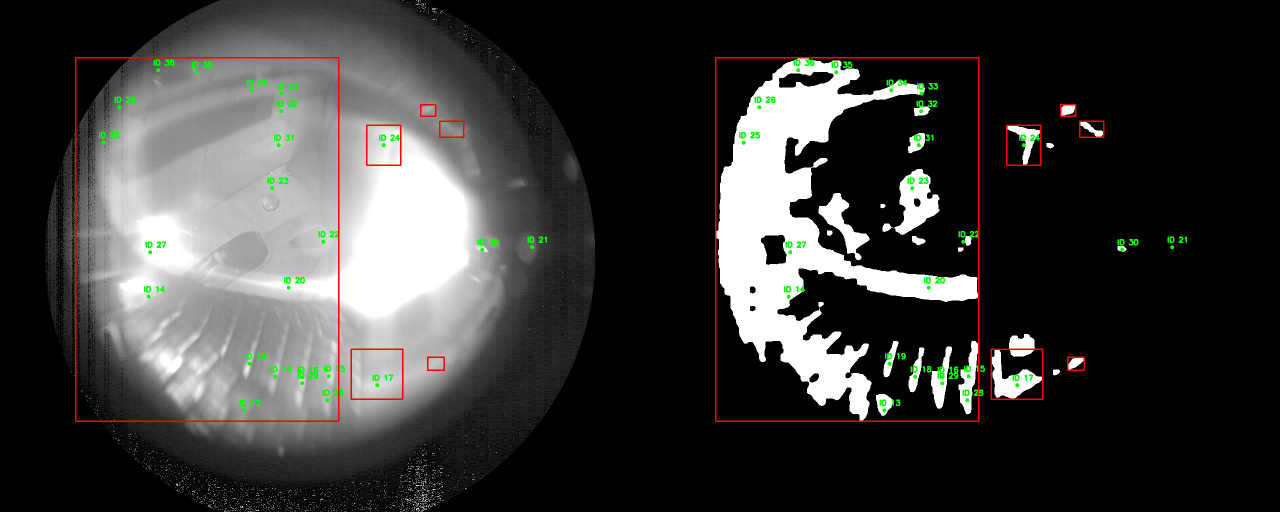

 16%|█▋        | 115/700 [02:26<12:29,  1.28s/it]

Deregistering object 33 after 50 frames


 17%|█▋        | 121/700 [02:34<12:18,  1.28s/it]

Deregistering object 25 after 50 frames
Deregistering object 26 after 50 frames


 18%|█▊        | 124/700 [02:37<12:05,  1.26s/it]

Deregistering object 14 after 50 frames


 18%|█▊        | 125/700 [02:39<12:02,  1.26s/it]

Deregistering object 36 after 50 frames


 18%|█▊        | 126/700 [02:40<11:56,  1.25s/it]

Deregistering object 30 after 50 frames


 18%|█▊        | 128/700 [02:42<11:46,  1.24s/it]

Deregistering object 35 after 50 frames


 19%|█▊        | 130/700 [02:45<11:37,  1.22s/it]

Deregistering object 27 after 50 frames


 20%|█▉        | 139/700 [02:55<11:07,  1.19s/it]

Deregistering object 28 after 50 frames


 20%|██        | 140/700 [02:57<11:04,  1.19s/it]

Deregistering object 23 after 50 frames


 20%|██        | 141/700 [02:58<11:00,  1.18s/it]

Deregistering object 13 after 50 frames


 21%|██        | 147/700 [03:05<11:25,  1.24s/it]

Deregistering object 20 after 50 frames


 21%|██        | 148/700 [03:06<11:29,  1.25s/it]

Deregistering object 21 after 50 frames
Deregistering object 22 after 50 frames


 22%|██▏       | 154/700 [03:14<11:23,  1.25s/it]

Deregistering object 34 after 50 frames


 23%|██▎       | 160/700 [03:21<11:04,  1.23s/it]

Deregistering object 17 after 50 frames
Deregistering object 24 after 50 frames


 28%|██▊       | 194/700 [04:03<10:22,  1.23s/it]

Deregistering object 37 after 50 frames
Deregistering object 47 after 50 frames


 28%|██▊       | 199/700 [04:09<10:03,  1.20s/it]

Deregistering object 44 after 50 frames


 29%|██▊       | 200/700 [04:10<09:59,  1.20s/it]

Deregistering object 32 after 50 frames


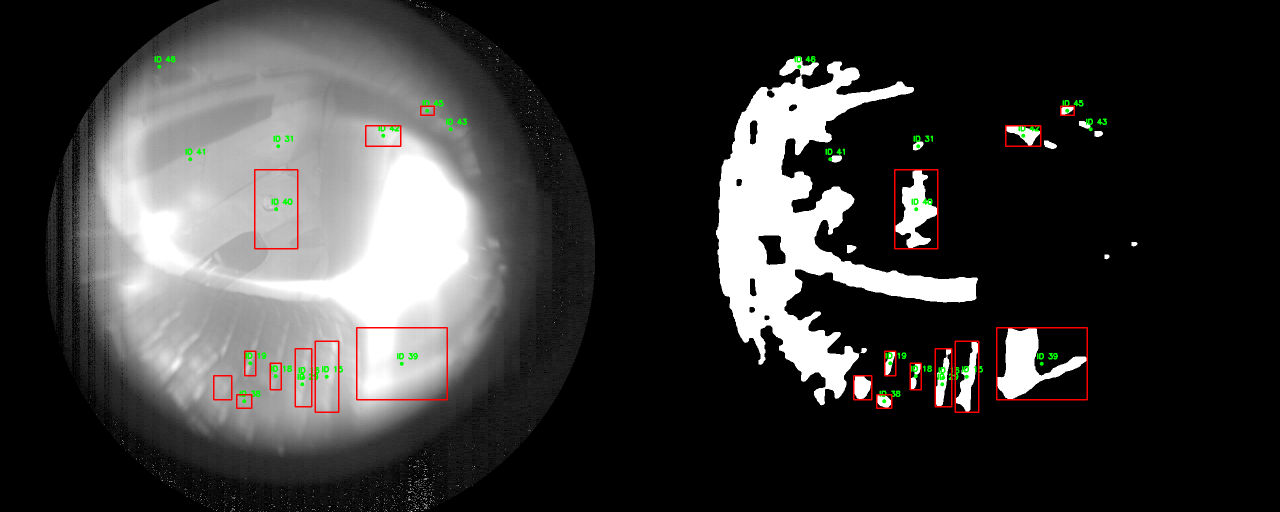

 30%|██▉       | 208/700 [04:19<09:41,  1.18s/it]

Deregistering object 31 after 50 frames


 43%|████▎     | 300/700 [06:10<08:01,  1.20s/it]

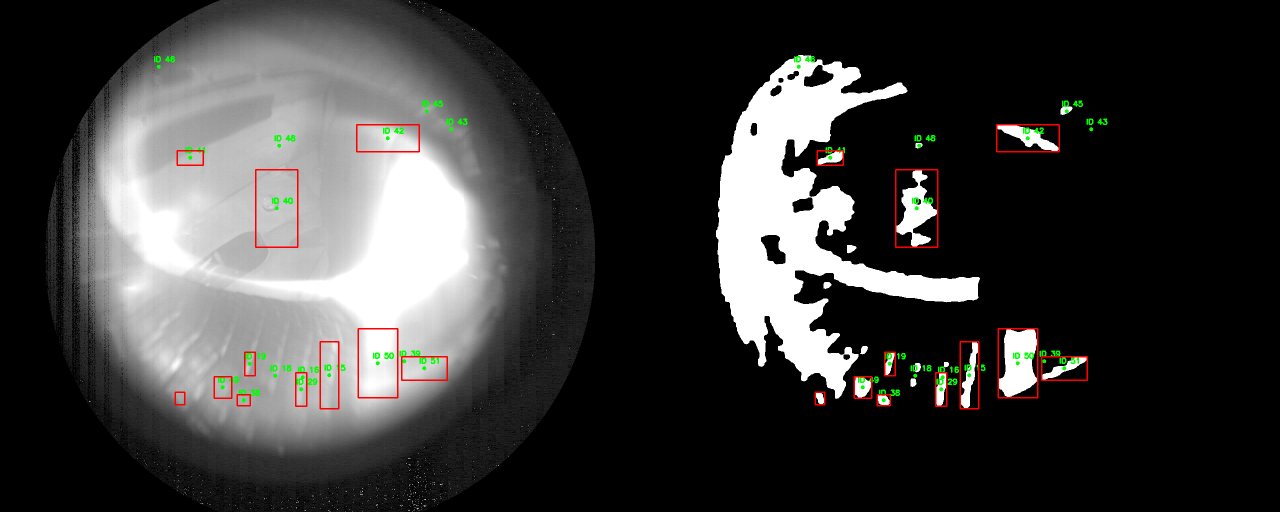

 44%|████▍     | 309/700 [06:21<07:48,  1.20s/it]

Deregistering object 46 after 50 frames


100%|██████████| 700/700 [06:58<00:00,  1.67it/s]


Elapsed time calibrating: 418.22901344299316
Elapsed time: 521.912397146225


In [19]:
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        # if file.endswith('.h5'):
        if file == (EXAMPLE_FILE + '.h5'):

            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]

            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + '/' + file

                [T1, T4, T4e] = archive.getT1T4(file)

                sequenceProcessor = sequenceAnalyzer.sequenceAnalyzer(sourceFile, T1, T4, T4e)

                print('Analyzing video sequence...')
                classify = False
                sequenceProcessor.processSequence(showBinarized = True, trackDetections = True, classifyDetections= classify)

                elapsed = time.time() - t

                print('Elapsed time: {}'.format(elapsed))

### generate_track_database.py (11)
Same as the block before with Classify=True that stores the object **tracker**

20171207.039_AEQ11.h5
Loading sequence file...
Elapsed time reading: 85.86987853050232
Computing Dark image...
Elapsed time computing dark image: 4.686164379119873
Computing Dark image...


  0%|          | 0/700 [00:00<?, ?it/s]

Elapsed time computing dark image: 2.2815396785736084
Analyzing video sequence...
Processing Sequence image...


  2%|▏         | 17/700 [03:33<3:41:25, 19.45s/it]/content/drive/MyDrive/Colab Notebooks/TFG/utils/imageAnalysis.py:211: UserWarning: Warning: converting a masked element to nan.
  characteristics.append(float(feature))
  3%|▎         | 23/700 [05:37<3:52:46, 20.63s/it]/content/drive/MyDrive/Colab Notebooks/TFG/utils/imageAnalysis.py:211: UserWarning: Warning: converting a masked element to nan.
  characteristics.append(float(feature))
  3%|▎         | 24/700 [05:58<3:51:38, 20.56s/it]/content/drive/MyDrive/Colab Notebooks/TFG/utils/imageAnalysis.py:211: UserWarning: Warning: converting a masked element to nan.
  characteristics.append(float(feature))
  4%|▎         | 25/700 [06:18<3:50:54, 20.53s/it]/content/drive/MyDrive/Colab Notebooks/TFG/utils/imageAnalysis.py:211: UserWarning: Warning: converting a masked element to nan.
  characteristics.append(float(feature))
  4%|▎         | 26/700 [06:39<3:50:22, 20.51s/it]/content/drive/MyDrive/Colab Notebooks/TFG/utils/imageAnalysis.py:211:

Deregistering object 0 after 50 frames
Deregistering object 1 after 50 frames
Deregistering object 2 after 50 frames
Deregistering object 3 after 50 frames
Deregistering object 4 after 50 frames
Deregistering object 5 after 50 frames


  9%|▉         | 62/700 [19:58<4:38:20, 26.18s/it]

Deregistering object 9 after 50 frames
Deregistering object 10 after 50 frames
Deregistering object 11 after 50 frames
Deregistering object 12 after 50 frames


  9%|▉         | 65/700 [21:34<5:26:05, 30.81s/it]

Deregistering object 8 after 50 frames


 10%|▉         | 69/700 [24:00<6:05:07, 34.72s/it]

Deregistering object 6 after 50 frames


 10%|█         | 72/700 [25:17<5:02:59, 28.95s/it]

Deregistering object 7 after 50 frames


 14%|█▍        | 100/700 [37:18<4:16:45, 25.68s/it]

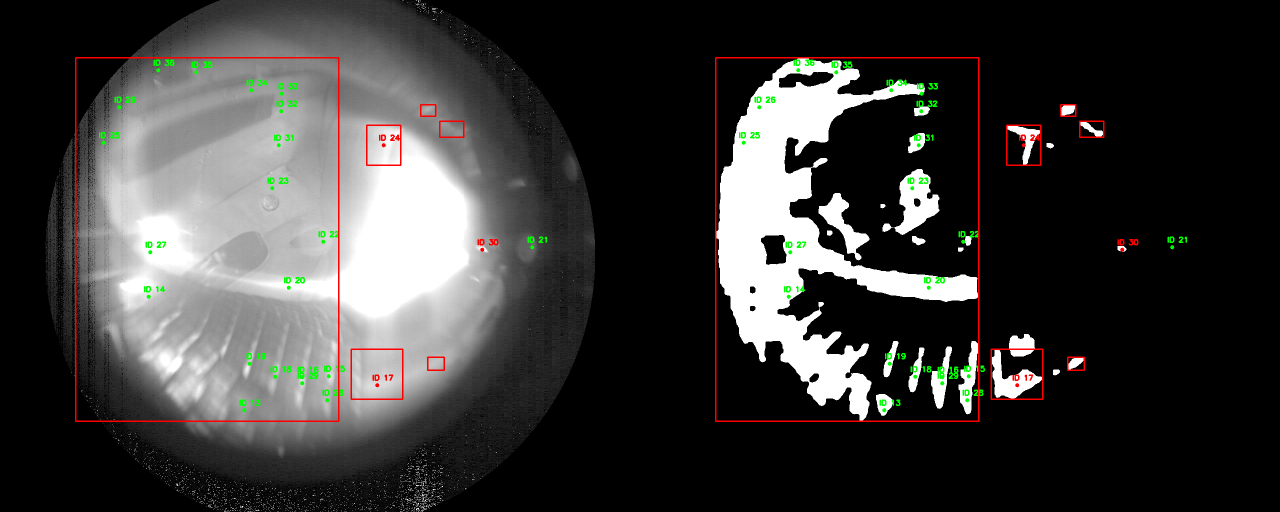

 16%|█▋        | 115/700 [43:44<4:11:28, 25.79s/it]

Deregistering object 33 after 50 frames


 17%|█▋        | 121/700 [46:16<4:06:27, 25.54s/it]

Deregistering object 25 after 50 frames
Deregistering object 26 after 50 frames


 18%|█▊        | 124/700 [47:30<3:59:03, 24.90s/it]

Deregistering object 14 after 50 frames


 18%|█▊        | 125/700 [47:49<3:41:59, 23.16s/it]

Deregistering object 36 after 50 frames


 18%|█▊        | 126/700 [48:08<3:28:33, 21.80s/it]

Deregistering object 30 after 50 frames


 18%|█▊        | 128/700 [48:44<3:10:22, 19.97s/it]

Deregistering object 35 after 50 frames


 19%|█▊        | 130/700 [49:20<2:58:41, 18.81s/it]

Deregistering object 27 after 50 frames


 20%|█▉        | 139/700 [50:49<1:36:22, 10.31s/it]

Deregistering object 28 after 50 frames


 20%|██        | 140/700 [50:59<1:33:50, 10.05s/it]

Deregistering object 23 after 50 frames


 20%|██        | 141/700 [51:08<1:30:37,  9.73s/it]

Deregistering object 13 after 50 frames


 21%|██        | 147/700 [52:24<2:04:39, 13.52s/it]

Deregistering object 20 after 50 frames


 21%|██        | 148/700 [52:38<2:05:47, 13.67s/it]

Deregistering object 21 after 50 frames
Deregistering object 22 after 50 frames


 22%|██▏       | 154/700 [53:58<2:01:11, 13.32s/it]

Deregistering object 34 after 50 frames


 23%|██▎       | 160/700 [55:14<1:53:48, 12.65s/it]

Deregistering object 17 after 50 frames
Deregistering object 24 after 50 frames


 28%|██▊       | 194/700 [1:01:29<1:33:16, 11.06s/it]

Deregistering object 37 after 50 frames
Deregistering object 47 after 50 frames


 28%|██▊       | 199/700 [1:02:20<1:26:38, 10.38s/it]

Deregistering object 44 after 50 frames


 29%|██▊       | 200/700 [1:02:29<1:24:43, 10.17s/it]

Deregistering object 32 after 50 frames


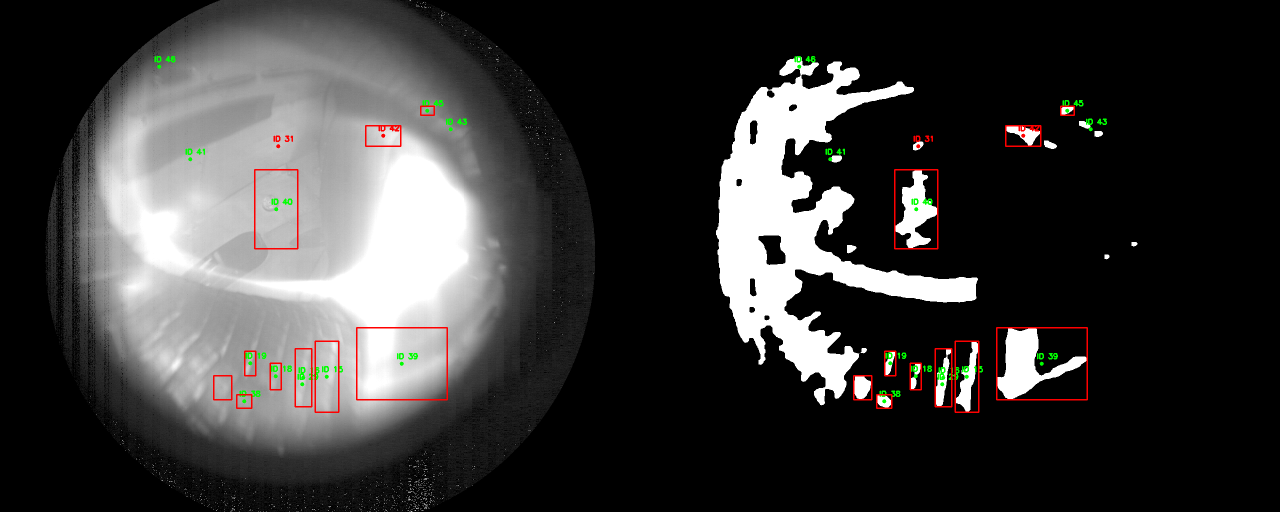

 30%|██▉       | 208/700 [1:03:43<1:15:11,  9.17s/it]

Deregistering object 31 after 50 frames


 43%|████▎     | 300/700 [1:20:36<1:13:27, 11.02s/it]

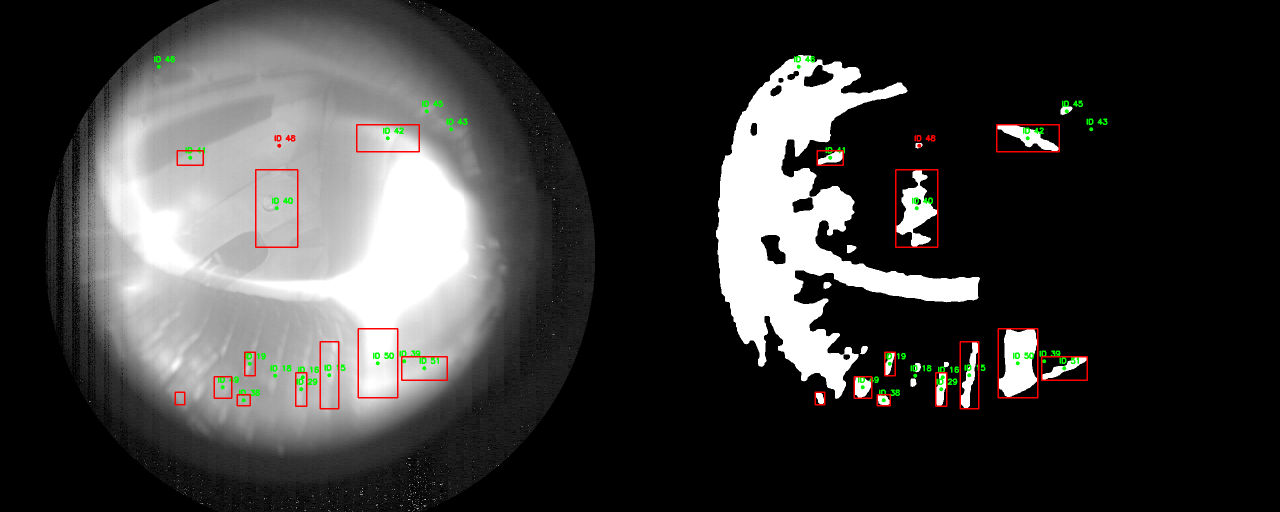

 44%|████▍     | 309/700 [1:22:16<1:11:41, 11.00s/it]

Deregistering object 46 after 50 frames


100%|██████████| 700/700 [1:24:36<00:00,  7.25s/it]


Elapsed time calibrating: 5076.750772476196
Elapsed time: 5190.962595701218


In [20]:
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        # if file.endswith('.h5'):
        if file == (EXAMPLE_FILE + '.h5'):

            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]

            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + '/' + file

                [T1, T4, T4e] = archive.getT1T4(file)

                sequenceProcessor = sequenceAnalyzer.sequenceAnalyzer(sourceFile, T1, T4, T4e)

                print('Analyzing video sequence...')
                classify = True
                sequenceProcessor.processSequence(showBinarized = True, trackDetections = True, classifyDetections= classify)

                elapsed = time.time() - t

                print('Elapsed time: {}'.format(elapsed))

### label_track_database.py (12)

This file load the object **tracker** created and stored in the previous block to label manually the tracks found. In the next block only the first 2 tracks will be labeled to show how it works but this is done for all the tracks found and all accessible sequences.

20171207.039_AEQ11.h5


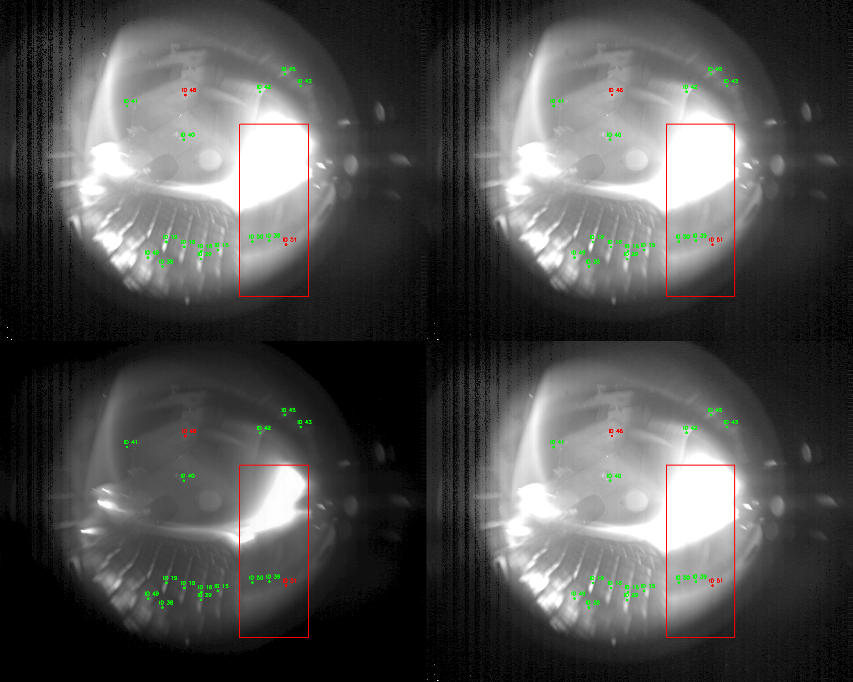

Track: 1, of a total of 52 tracks
Detected Object with ID: 0
Anomaly? None == not fund; a == anomaly, other == HotSpotother
hot spot


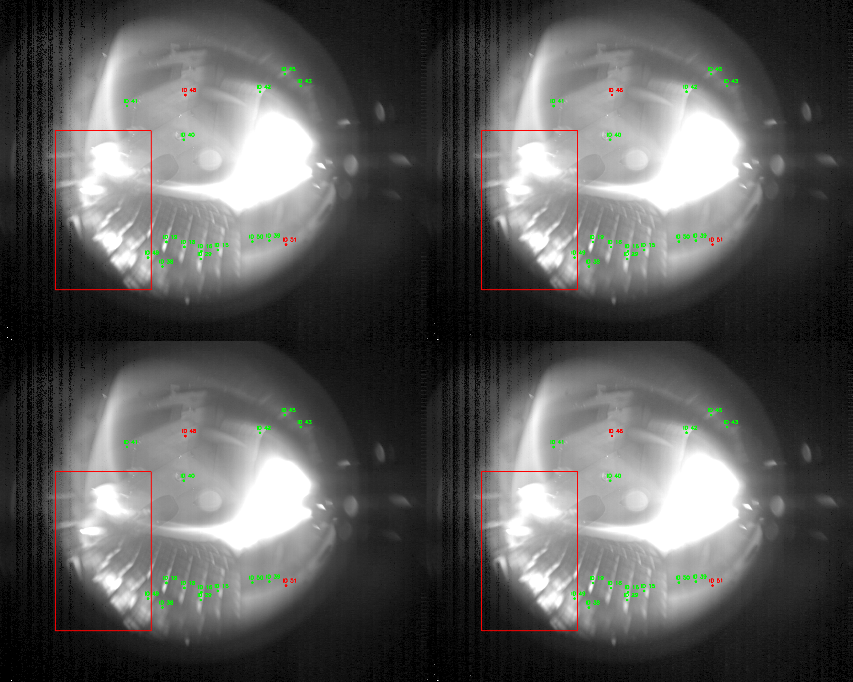

Track: 2, of a total of 52 tracks
Detected Object with ID: 1
Anomaly? None == not fund; a == anomaly, other == HotSpotother
hot spot


In [22]:
i = 0
tracks = 0
dets = 0
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        # if file.endswith('.h5')
        if file == EXAMPLE_FILE + '.h5':

            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:
                print(file)
                sourceFile = dirpath + '/' + file

                seqName = os.path.basename(sourceFile)
                # Load sequence tracker
                # As we have only done the tracker.joblib for our EXAMPLE_FILE,
                # we only have one tracker
                trackername = 'trackerTRACKS'+ '.joblib'
                trackername = PROJECT_ROOT + '/models/' + trackername

                # File in which the characteristics of each track will be stored
                filename = PROJECT_ROOT + '/tests/characteristics_tracks/' + file + '.json' 

                # Original: if not os.path.exists(filename):
                if os.path.exists(filename):
                    tracker = joblib.load(trackername)
                    """
                    aux = 0
                    for objectID in sorted(tracker.trackableObjects.keys()):
                        trackData = tracker.trackableObjects[objectID]
                        aux = aux + len(trackData.centroids)
                        dataset = []
                        saveData(filename, dataset)
                    dets = dets + aux
                    print(aux)
                    print (dets)
                    """

                    #Obtain thumbnail image
                    maxImage = tracker.trackableObjects[0].imageThumbnail
                    max = np.percentile(maxImage, 95)
                    maxImage = image_tools.rescaleImage(maxImage, colormap_max=max)
                    maxImage = image_tools.adjustGamma(maxImage, 2)
                    dataset = []
                    nTracks = len(tracker.trackableObjects)
                    tracks = 0

                    # Original: for objectID in sorted(tracker.trackableObjects.keys()):
                    for objectID in range(2):

                        tracks = tracks + 1
                        trackData = tracker.trackableObjects[objectID]
                        detections = []

                        #Resize detection
                        increaseFactor = 0.5
                        detection = trackData.characteristics[-1][1]
                        x1 = detection[0]
                        y1 = detection[1]
                        x2 = detection[2]
                        y2 = detection[3]
                        w = x2 - x1
                        h = y2 - y1
                        x1 = np.min([1280,np.max( [0,int(x1 - increaseFactor * w)])])
                        y1 = np.min([1024,np.max( [0,int(y1 - increaseFactor * h)])])
                        x2 = np.min([1280,np.max( [0,int(x2 + increaseFactor * w)])])
                        y2 = np.min([1024,np.max( [0,int(y2 + increaseFactor * h)])])
                        detection = [x1,y1,x2,y2]

                        detections.append(detection)

                        #Obtain Track Thumbnail
                        trackThumbnail = trackData.imageThumbnail
                        max = np.percentile(trackThumbnail, 95)
                        trackThumbnail = image_tools.rescaleImage(trackThumbnail, colormap_max=max)
                        trackThumbnail = image_tools.adjustGamma(trackThumbnail, 2)

                        #Obtain Track Enhanced
                        trackThumbnailEnhanced = trackData.imageThumbnail
                        croppedImage = trackThumbnailEnhanced[y1: y2, x1: x2]
                        max = np.percentile(croppedImage, 95)
                        min = np.min(croppedImage)
                        trackThumbnailEnhanced = image_tools.rescaleImage(trackThumbnailEnhanced,colormap_min=min, colormap_max=max)
                        trackThumbnailEnhanced = image_tools.adjustGamma(trackThumbnailEnhanced, 2)

                        #Plot centroid and BBox
                        trackThumbnail = tracker.plotTracks(trackThumbnail)
                        trackThumbnail = image_tools.plotBBoxes(trackThumbnail, detections)
                        visualizeImage = tracker.plotTracks(maxImage)
                        visualizeImage = image_tools.plotBBoxes(visualizeImage, detections)
                        trackThumbnailEnhanced = tracker.plotTracks(trackThumbnailEnhanced)
                        trackThumbnailEnhanced= image_tools.plotBBoxes(trackThumbnailEnhanced, detections)

                        #Stack Thumbnails
                        imageStacked1 = np.hstack((visualizeImage, trackThumbnail))
                        imageStacked2= np.hstack((trackThumbnailEnhanced, visualizeImage))
                        imageStacked = np.vstack((imageStacked1, imageStacked2))
                        imageStacked = cv2.resize(imageStacked,
                                                    (int(imageStacked.shape[1] / 3),
                                                    int(imageStacked.shape[0] / 3)))
                        image_tools.showImage(imageStacked)

                        print('Track: {0}, of a total of {1} tracks'.format(tracks, nTracks))
                        print('Detected Object with ID: {}'.format(objectID))
                        # sleep to avoid the notebook crashing
                        time.sleep(3)
                        value = input("Anomaly? None == not fund; a == anomaly, other == HotSpot")
                        anomaly = False
                        hotSpot = False
                        # Mark as anomaly detections labaled with value diferent than 0
                        if value != "":
                            anomaly = True
                            if value != 'a':
                                hotSpot = True
                                print('hot spot')
                            else:
                                print('anomaly')
                        else:
                            print ('not found')

                        for element in trackData.characteristics:
                            frameID = element[0]
                            detection = element[1]
                            characteristics = element[2]

                            if anomaly:

                                if hotSpot:
                                    #1 --> Hot Spot
                                    blobCharacteristics = [frameID, objectID,
                                                        detection[0], detection[1], detection[2], detection[3],
                                                        1]
                                else:
                                    # 2 --> anomaly
                                    blobCharacteristics = [frameID, objectID,
                                                            detection[0], detection[1], detection[2], detection[3],
                                                            2]

                            else:
                                # 0 --> No Hot Spot / anomaly
                                blobCharacteristics = [frameID, objectID,
                                                        detection[0], detection[1], detection[2], detection[3],
                                                        0]

                            if characteristics != []:
                                for characteristic in characteristics:
                                    blobCharacteristics.append(characteristic)

                            dataset.append(blobCharacteristics)

                    JSONLoader.saveData(filename, dataset)

Now we will have stored all the detections stored by trackID. In other words, firs we will have all the detections in different frame of the trackID number 0, then all the detections corresponding to frameID number 1. We can see that in the following block in which we look the .json file created in the previous block.

In [24]:
path = PROJECT_ROOT + '/tests/characteristics_tracks/' + EXAMPLE_FILE + '.h5.json'
detections = JSONLoader.loadData(path)

print('The first 2 track detections are:')
for d in detections:
    print(d[0:6])

The first 2 track detections are:
[1, 0, 771, 502, 874, 761]
[2, 0, 771, 502, 874, 761]
[3, 0, 771, 502, 874, 761]
[4, 0, 771, 502, 874, 761]
[5, 0, 771, 502, 874, 761]
[6, 0, 771, 502, 874, 761]
[7, 0, 771, 502, 874, 761]
[8, 0, 771, 502, 874, 761]
[9, 0, 771, 502, 874, 761]
[10, 0, 771, 502, 874, 761]
[11, 0, 771, 502, 874, 761]
[12, 0, 771, 502, 874, 761]
[13, 0, 771, 502, 874, 761]
[14, 0, 771, 502, 874, 761]
[15, 0, 771, 502, 874, 761]
[16, 0, 771, 502, 874, 761]
[17, 0, 771, 502, 874, 761]
[18, 0, 771, 502, 874, 761]
[19, 0, 771, 502, 874, 761]
[20, 0, 771, 502, 874, 761]
[21, 0, 771, 502, 874, 761]
[22, 0, 771, 502, 874, 761]
[23, 0, 771, 502, 874, 761]
[24, 0, 771, 502, 874, 761]
[25, 0, 771, 502, 874, 761]
[26, 0, 771, 502, 874, 761]
[27, 0, 771, 502, 874, 761]
[28, 0, 771, 502, 874, 761]
[29, 0, 771, 502, 874, 761]
[30, 0, 771, 502, 874, 761]
[31, 0, 771, 502, 874, 761]
[32, 0, 771, 502, 874, 761]
[33, 0, 771, 502, 874, 761]
[34, 0, 771, 502, 874, 761]
[35, 0, 771, 502, 874, 

We can see how the track detections are stored. We can observe that both track detections are stationary for the whole track and both of them are 53 frames long. It is a coincidence or a general factor that has affected the sequence that both tracks have the same length. If this code is tested with diferent tracks it can be seen that some tracks have little movement and do not have the same length. It also can be seee in the definitive files that the tracks have different lengths and a little movement.

### train_classifiers _tracks.py (13)
This file trains and test the SVM classifier and all the parameters available. As the time needed to run this block is too long and the google colab stops the runtime environment after some time, the following block has been runed in the Image Processing Group Servers.

In [ ]:
sequencesToAnalyze = ["20180906.036_AEQ10.h5","20180906.036_AEQ51.h5","20171207.039_AEQ11.h5",
                        "20171207.043_AEQ11.h5", "20180918.036_AEQ50.h5" , "20180918.038_AEQ50.h5",
                        "20171207.039_AEQ11.h5", "20171207.043_AEQ11.h5", "20180906.036_AEQ10.h5",
                        "20180906.036_AEQ51.h5", "20180918.036_AEQ50.h5", "20180918.038_AEQ50.h5",
                        "20180918.040_AEQ50.h5", "20180919.007_AEQ40.h5", "20180920.034_AEQ11.h5",
                        "20181002.028_AEQ20.h5", "20181004.038_AEQ10.h5", "20181004.038_AEQ20.h5",
                        "20181004.038_AEQ40.h5", "20181004.046_AEQ20.h5", "20181004.046_AEQ40.h5",
                        "20181004.046_AEQ50.h5", "", "",
                        "", "", "",
                        ]

init = True
n=0

for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:

        if file.endswith('.h5') and (file in sequencesToAnalyze):
            t = time.time()

            filename, _ = os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]
            if [xp, port] in data:

                sourceFile = dirpath + '/' + file

                #try:

                filename = PROJECT_ROOT + '/data/Sequence Labeled/' + file + '.json'
                characteristics = JSONLoader.loadData(filename)

                nBins = 256

                sequenceData = classification.arrangeData(characteristics)

                if init:
                    xData = np.nan_to_num(sequenceData[7:, :])
                    yData = sequenceData[6,:]
                    init = False
                    n = n+1
                else:
                    xData = np.concatenate((xData, np.nan_to_num(sequenceData[7:, :])), axis = 1)
                    yData = np.concatenate((yData,sequenceData[6, :]), axis = 0)
                    n = n + 1

#Get test data
path = PROJECT_ROOT + '/data/Sequence Labeled/'
initTrain = True
for (dirpath, dirnames, filenames) in walk(path):
    for file in filenames:
        if file.endswith('.json'):
            characteristics = JSONLoader.loadData(filename)

            nBins = 256

            sequenceData = classification.arrangeData(characteristics)

            if init:
                xDataTest = np.nan_to_num(sequenceData[7:, :])
                yDataTest = sequenceData[6, :]            
                initTrain = False
            else:
                xDataTest = np.concatenate((xData, np.nan_to_num(sequenceData[7:, :])), axis=1)
                yDataTest = np.concatenate((yData, sequenceData[6, :]), axis=0)

#Train SVM
"""for i in range(2, 10):
    clf = data_classifier(n=i, multiclass=True)
    xData_normalized = clf.normalize_data(xData)
    print('Training SVM with {} PCA components'.format(i))
    clf.cross_validate(xData_normalized, yData)
exit()"""

searchN = False
if not searchN:
    clf = classification.data_classifier(n=8, classifier = "RF", multiclass= False)
    xData_normalized = clf.normalize_data(xData)
    clf.train_classifier_precision_recall_curve(xData_normalized, yData)
    # clf.train_classifier_GS(xData_normalized, yData, groups=5 )
    classification.saveModel(clf, fileName='classification_tracks.joblib')
    xDataTrain_normalized = clf.normalize_data(xDataTest, fit = False)
    clf.predictLabel(xDataTrain_normalized, yDataTest)
    clf.probability(xDataTrain_normalized, yDataTest)
    threshold = 0.5
    clf.predict_probability(xDataTrain_normalized, yDataTest,threshold)



else:
    for i in range(2,10):
        clf = classification.data_classifier(n=i, multiclass= False)
        xData_normalized = xData
        n#clf.normalize_data(xData)
        print('Training SVM with {} PCA components'.format(i))
        clf.grid_search(xData_normalized, yData)



elapsed = time.time() - t
print('Elapsed time: {}'.format(elapsed))

# dimensionality reduction
# TSNE = False

# if TSNE:
#     n_components = 2
#     perplexity = 5

#     tsne = manifold.TSNE(n_components=n_components, verbose=1, init='random',
#                             random_state=0, perplexity=perplexity)
#     Y = tsne.fit(xData.transpose())
#     Y_2 = tsne.fit_transform(xData.transpose())

#     a = Y_2[:, 0]
#     b = Y_2[:, 1]

#     scatterPlot(a, b, '', '', yData)

The result is the following:

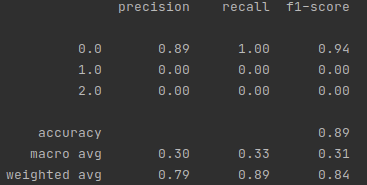